In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '18'
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.facecolor'] = 'white'

import numpy as np
import xarray as xr
import pandas as pd
from tqdm import tqdm
import nctoolkit as nc
import datetime


import os, sys, webbrowser

from dask import delayed, compute
from dask.distributed import Client, LocalCluster

cluster = LocalCluster(scheduler_port=8786, n_workers=5, threads_per_worker=1)
client_dask = Client(address=cluster)
webbrowser.open(client_dask.dashboard_link, new=2)

module_path = os.path.abspath(os.path.join('/Users/gilaverbuch/dev/pysst/'))
if module_path not in sys.path:
    sys.path.appendp(module_path)
from src.pysst.pysst import load_data


nctoolkit is using Climate Data Operators version 2.2.0


In [2]:
date_i = '2019-06-10T15:00'
date_f = '2019-06-11T15:00'

date_i = np.datetime64(date_i)
date_f = np.datetime64(date_f)



In [3]:
ds1 = nc.open_thredds('http://tds.maracoos.org/thredds/dodsC/AVHRR/2019/1Agg')
dsx1 = ds1.to_xarray()
dsx1 = dsx1.sortby('time')

In [4]:
day_avg_1 = dsx1.sel(time=slice(date_i, date_f))

In [5]:
day_avg_1

<xarray.Dataset>
Dimensions:  (lon: 4500, lat: 3661, time: 6)
Coordinates:
  * lon      (lon) float64 -100.0 -99.99 -99.98 -99.97 ... -50.02 -50.01 -50.0
  * lat      (lat) float64 20.0 20.01 20.02 20.03 ... 51.98 51.99 51.99 52.0
  * time     (time) datetime64[ns] 2019-06-10T19:56:00 ... 2019-06-11T13:47:00
Data variables:
    mcsst    (time, lat, lon) float32 ...
Attributes: (12/22)
    url:                       http://www.ceoe.udel.edu, http://marine.rutger...
    groundstation:             RU-COOL L-band receiver at Rutgers University,...
    creator_name:              Matt Oliver
    creator_email:             moliver@udel.edu
    institution:               University of Delaware
    source:                    NOAA AVHRR
    ...                        ...
    publisher_url:             http://maracoos.org
    Conventions:               ACDD-1.3, CF-1.6
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    NCO:                       4.0.8
    composite_members:          20191231.2031 20191231.2031 20191231.2031 201...
    license:                   Freely Distributed

In [6]:
ds2 = nc.open_thredds('http://basin.ceoe.udel.edu/thredds/dodsC/avhrr_unfiltered_sst.nc')
dsx2 = ds2.to_xarray()
dsx2 = dsx2.sortby('time')

In [7]:
day_avg_2 = dsx2.sel(time=slice(date_i, date_f))

In [8]:
day_avg_2

<xarray.Dataset>
Dimensions:          (lon: 4500, lat: 3661, time: 6)
Coordinates:
  * lon              (lon) float64 -100.0 -99.99 -99.98 ... -50.02 -50.01 -50.0
  * lat              (lat) float64 20.0 20.01 20.02 20.03 ... 51.99 51.99 52.0
  * time             (time) datetime64[ns] 2019-06-10T19:56:00 ... 2019-06-11...
Data variables:
    crs              int32 ...
    sat              (time) float64 ...
    mcsst            (time, lat, lon) float32 ...
    cloud_land_mask  (time, lat, lon) float64 ...
Attributes: (12/21)
    url:                       http://www.ceoe.udel.edu, http://marine.rutger...
    groundstation:             RU-COOL L-band receiver at Rutgers University,...
    history:                    
    creator_name:              Matt Oliver
    creator_email:             moliver@udel.edu
    institution:               University of Delaware
    ...                        ...
    publisher_name:            MARACOOS DMAC
    publisher_email:           maracoosinfo@udel.edu
    publisher_url:             http://maracoos.org
    Conventions:               CF-1.6
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    NCO:                       4.0.8

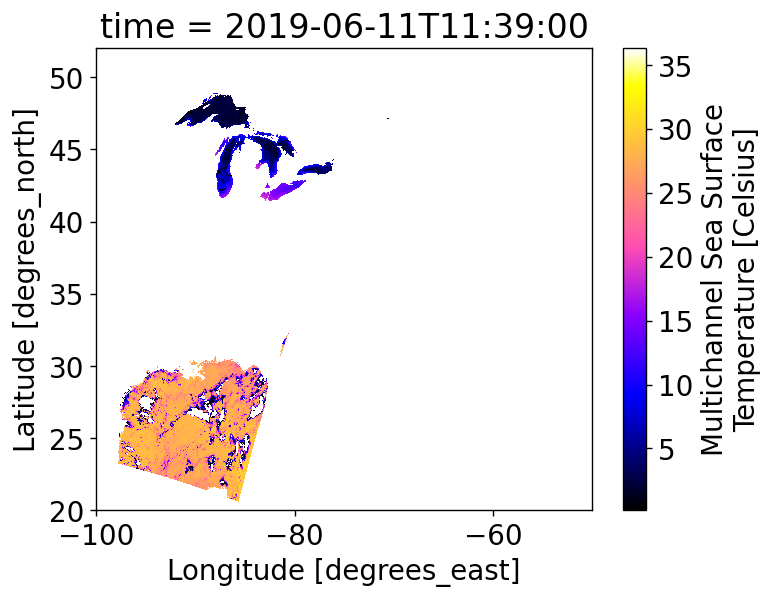

In [9]:
day_avg_2.isel(time=4).mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [56]:
temp = day_avg_2.mean(dim=["time"], skipna=True)

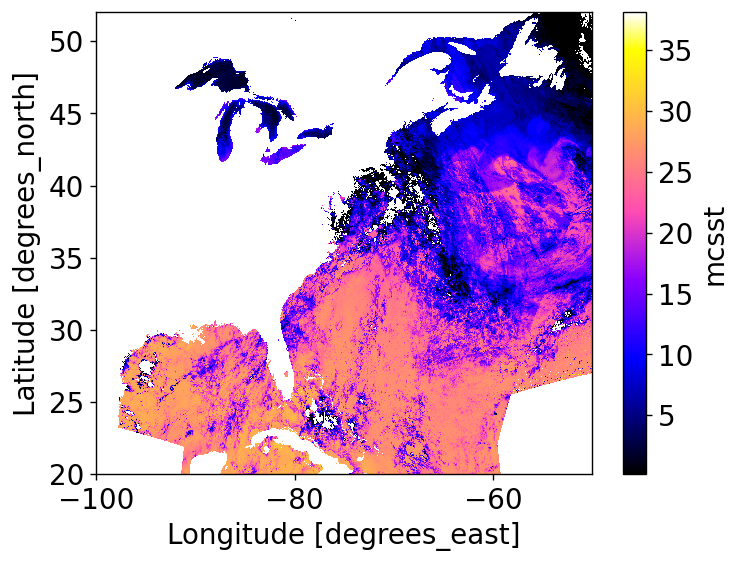

In [57]:
temp.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [23]:
def mean_sst(xr1, xr2):
    '''
    Cal;culating the mean SST of two datasets
    '''
    xr_ = xr1.copy()
    xr_.mcsst.values = np.nanmean(np.dstack((xr1.mcsst.values,xr2.mcsst.values)),2)
    
    return xr_

def mean_sst_v2(xr1, xr2):
    '''
    Cal;culating the mean SST of two datasets
    '''
    
    xr_ = np.nanmean(np.dstack((xr1,xr2)),2)
    
    return xr_

In [34]:
%%time
dsx = day_avg_1.copy()
days = np.arange(0,day_avg_1.time.size,1)
days = np.arange(0,5,1)

out = []
for i in days:
    
#     a = delayed(mean_sst)(day_avg_1.isel(time=i), day_avg_2.isel(time=i))
    a = delayed(mean_sst_v2)(day_avg_1.isel(time=i).mcsst.values, day_avg_2.isel(time=i).mcsst.values)
    
    out.append(a)
    
    
    

CPU times: user 7.37 s, sys: 1.88 s, total: 9.25 s
Wall time: 26.3 s


In [35]:
%%time
out = compute(*out)

CPU times: user 370 ms, sys: 908 ms, total: 1.28 s
Wall time: 1.73 s


In [33]:
out

(<xarray.Dataset>
 Dimensions:  (lon: 4500, lat: 3661)
 Coordinates:
   * lon      (lon) float64 -100.0 -99.99 -99.98 -99.97 ... -50.02 -50.01 -50.0
   * lat      (lat) float64 20.0 20.01 20.02 20.03 ... 51.98 51.99 51.99 52.0
     time     datetime64[ns] 2019-06-10T19:56:00
 Data variables:
     mcsst    (lat, lon) float32 nan nan nan nan nan ... 0.15 0.15 0.15 0.15 0.15
 Attributes: (12/22)
     url:                       http://www.ceoe.udel.edu, http://marine.rutger...
     groundstation:             RU-COOL L-band receiver at Rutgers University,...
     creator_name:              Matt Oliver
     creator_email:             moliver@udel.edu
     institution:               University of Delaware
     source:                    NOAA AVHRR
     ...                        ...
     publisher_url:             http://maracoos.org
     Conventions:               ACDD-1.3, CF-1.6
     Metadata_Conventions:      Unidata Dataset Discovery v1.0
     NCO:                       4.0.8
     compos

In [17]:
out = xr.concat(out, 'time')

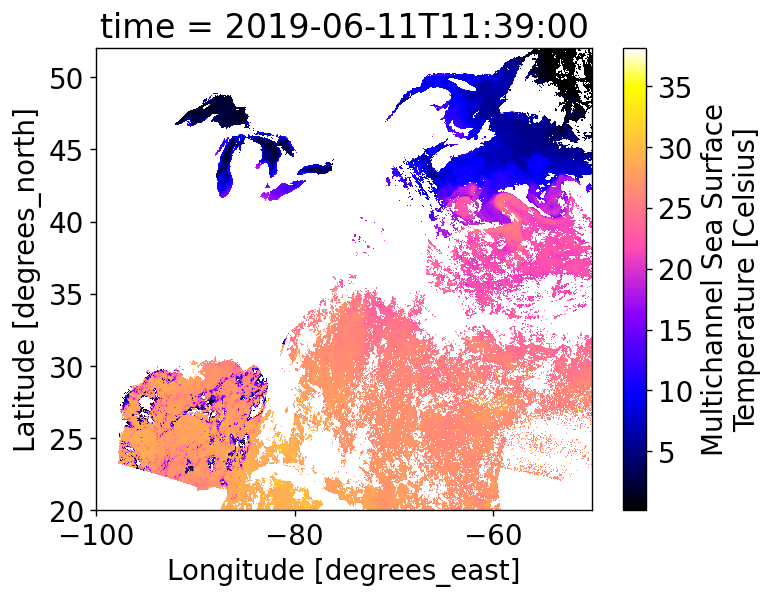

In [19]:
out.isel(time=4).mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [50]:
i=0
temp = xr.merge([day_avg_2.isel(time=i), day_avg_1.isel(time=i)], join="outer")

MergeError: conflicting values for variable 'mcsst' on objects to be combined. You can skip this check by specifying compat='override'.

In [ ]:
temp.mcsst.plot(cmap='gnuplot2', clim=(5,35))

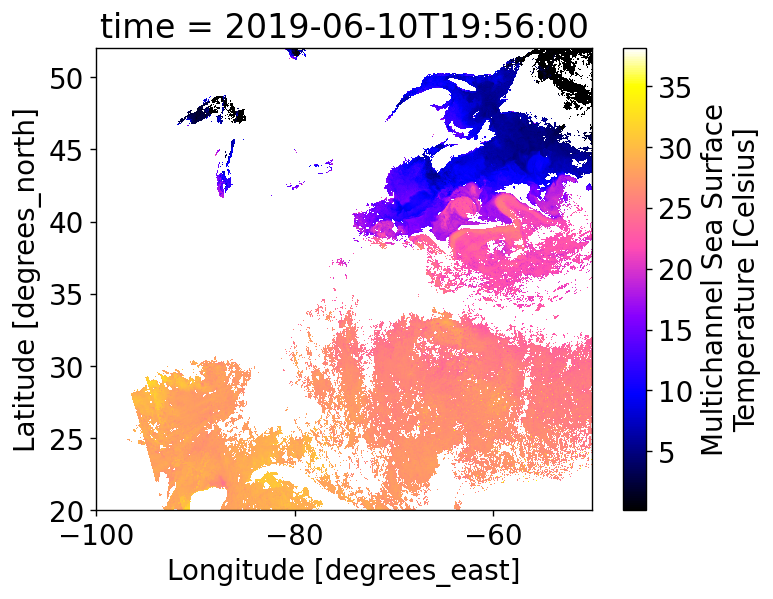

In [46]:
day_avg_1.isel(time=i).mcsst.plot(cmap='gnuplot2', clim=(5,35))

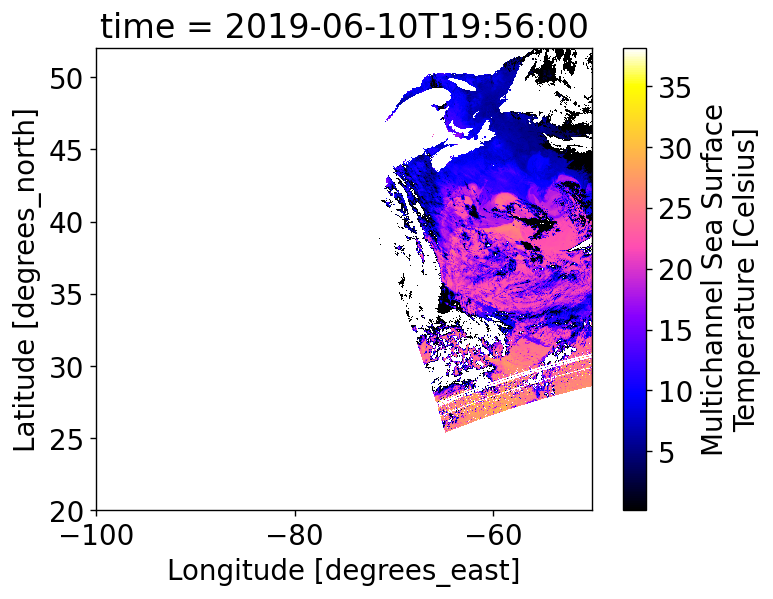

In [47]:
day_avg_2.isel(time=i).mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
    dsx.isel(time=i).mcsst.values = np.nanmean(np.dstack((day_avg_1.isel(time=i).mcsst.values,
                                                          day_avg_2.isel(time=i).mcsst.values)),2)

In [ ]:
dsx.isel(time=5).mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
dsx3 = day_avg_1.copy()


dsx3.mcsst.values = np.nanmean(np.dstack((day_avg_1.mcsst.values,day_avg_2.mcsst.values)),2)

In [ ]:
dsx1 = dsx1.sel(time=date, method='nearest', drop=True)


In [ ]:
# dsx1 = dsx1.sel(time=date, method='nearest')
dsx2 = dsx2.sel(time=date, method='nearest')

In [ ]:
dsx2

In [ ]:
dsx2

In [ ]:
dsx1.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
dsx2.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
dsx3 = dsx1.copy()

In [ ]:
dsx3.mcsst.values = np.nanmean(np.dstack((dsx1.mcsst.values,dsx2.mcsst.values)),2)

In [ ]:
dsx3

In [ ]:
dsx3.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
date = '2019-01-10T15:00'
date = np.datetime64(date)

In [ ]:
t 

In [ ]:
date = '2019-07-01T10:00'
t = np.datetime64(date)

dsx1 = dsx1.sel(time=t, method='nearest')

In [ ]:
dsx1.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
day_ang = dsx1.sel(time=slice('2019-07-01', '2019-07-01'))

In [ ]:
day_ang = dsx1.sel(time=slice('2019-07-01', '2019-07-01')).groupby('time.day').mean('time')

In [ ]:
day_ang

In [ ]:
day_ang.mcsst.plot(cmap='gnuplot2', clim=(5,35))

In [ ]:
abstime = np.abs(dsx.time-t)
abstime = np.timedelta64(abstime.time.values[0], 'h')
t_loc = np.where(abstime<=1)

# # Now I can use that index location to get the values at the x/y diminsion
# point_ds = ds.sel(x=xloc, y=yloc)

In [ ]:
abstime.time.values[0]

In [ ]:
a = xr_ds.isel(time=1500)

In [ ]:
a.mcsst.plot()

In [ ]:
d = a.mcsst.values.copy()
lat = a.lat.values.copy()
lon = a.lon.values.copy()
plt.figure(figsize=(15,10))
plt.pcolormesh(lon, lat,d, cmap='gnuplot2')
plt.clim(5,35)
plt.colorbar(label='Temp [c]')
plt.show()

In [ ]:
d = a.mcsst.values.copy()

In [ ]:
a.lat